In [1]:
from keras.models import Sequential                                                                                    
from keras.optimizers import Adam                                                                                      
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Lambda,Dropout                             
from keras.layers.convolutional import Convolution2D                                                                   
from keras.utils import np_utils                                                                                       
from keras.layers.advanced_activations import ELU                                                                      
                                                                                                                       
                                                                                                                       
from PIL import Image                                                                                                  
import cv2                                                                                                             
import numpy as np 


import json                                                                                                            
import argparse                                                                                                        
import time                                                                                                            
import os  
import math
                                                                                                                       
import tensorflow as tf                                                                                                
tf.python.control_flow_ops = tf                                                                                        
tf.logging.set_verbosity(tf.logging.ERROR)                                                                             
rows = 20                                                                                                              
cols = 40                                                                                                              
channels = 3                                                                                                           
                                                                                                                       
#data_dir = './data/combined_data/'                                                                                    
data_dir = './data/mattew_data/'                                                                                       
data_dir = './data/udacity_data/'                                                                                      
                                                                                                                       
test_data_dir = './data/test_data/' 

Using TensorFlow backend.


In [2]:
                                                                                                                       
def read_image(filename):                                                                                              
    newimage = Image.open(filename)                                                                                                                                                                  
    image_array = np.asarray(newimage)  
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    
    return image_array                                                                                                 
                                                                                                                       
                                                                                                                       
                                                                                                                       
                 

In [3]:
                                                                                                                       
def load_data(X,y,path):                                                                                               
    print('start loading data...')                                                                                     
    t = time.process_time()                                                                                            
    side_camera_adjustment = 0.4*np.random.random_sample()                                                             
    #side_camera_adjustment = .229                                                                                     
    f = open(path + '/driving_log.csv')                                                                                
    for line in f:                                                                                                     
        line = line.split(',')                                                                                         
                                                                                                                       
        # center camera                                                                                                
        im = read_image(path+'/'+line[0].strip()) # center image                                                       
        angle = float(line[3])                                                                                         
        X.append(im)                                                                                                   
        y.append(angle)                                                                                                
                                                                                                                       
                                                                                                                       
        #left camera                                                                                                   
        if line[1].strip():                                                                                            
            im = read_image(path+'/'+line[1].strip())                                                                  
            angle = angle + side_camera_adjustment # if this close, steer to the right                                 
            X.append(im)                                                                                               
            y.append(angle)                                                                                            
                                                                                                                       
                                                                                                                       
        #right camera                                                                                                  
        if line[2].strip():                                                                                            
            im = read_image(path+'/'+line[2].strip())                                                                  
            angle = angle - side_camera_adjustment # if this close, steer to the right                                 
            X.append(im)                                                                                               
            y.append(angle)                                                                                            
                                                                                                                       
    elapsed_time = time.process_time() - t                                                                                     
    print('end loading data ---~> {}'.format(elapsed_time))                                                            
                                                                                                      
                                                                                 
                                                                                                                       
    return X,y                                                                                                         
             

In [4]:
print('Comparing 3 frames...')                                                                                 
                                                                                                                       
X_test = []                                                                                                    
y_test = []                                                                                                    
X_test,y_test = load_data(X_test,y_test,test_data_dir)                                                         
X_test = np.array(X_test).astype('float32')                                                                    
y_test = np.array(y_test).astype('float32')                                                                    
print('X_test.shape: ',X_test.shape)                                                                           
print('Y_test.shape: ',y_test.shape)                                                                           
     

Comparing 3 frames...
start loading data...
end loading data ---~> 0.022106445000000363
X_test.shape:  (9, 160, 320, 3)
Y_test.shape:  (9,)


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

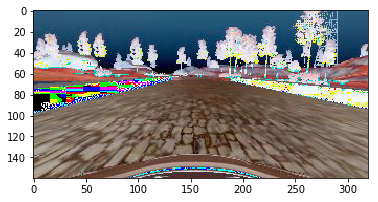

In [6]:
plt.imshow(X_test[0])

In [7]:
def random_shear(image,steering,prob=0.5):                                                                              
    # tnx: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.yozfr1waw       
    if np.random.random_sample() > prob:                                                                                
        rows = image.shape[0]                                                                                           
        cols = image.shape[1]                                                                                           
        shear_range = math.ceil(cols/3)                                                                                 
        dx = np.random.randint(-shear_range,shear_range+1)                                                              
        random_point = [cols/2+dx,rows/2]                                                                               
        pts1 = np.float32([[0,rows],[cols,rows],[cols/2,rows/2]])                                                       
        pts2 = np.float32([[0,rows],[cols,rows],random_point])                                                          
        #dsteering = dx/(rows/2) * 360/(2*np.pi*25.0) / 6.0                                                             
        dsteering = dx/(rows/2) * 360/(2*np.pi*25.0) / 2.0                                                              
        M = cv2.getAffineTransform(pts1,pts2)                                                                           
        image = cv2.warpAffine(image,M,(cols,rows),borderMode=1)                                                        
        steering +=dsteering                                                                                            
    return image,steering                                                                                               
                                                                                                                        
                                                                                                                        
def random_flip(im,angle,prob=0.5):                                                                                     
    if np.random.random_sample() > prob:                                                                                
        return np.fliplr(im),angle * -1.0                                                                               
    else:                                                                                                               
        return im,angle  

In [8]:
rows = 20
cols = 40
def process_image(image_array,y):                                                                                       
    # crop the image                                                                                                    
    top = math.ceil(image_array.shape[0]*0.30)                                                                          
    bot = math.ceil(image_array.shape[0]-image_array.shape[0]*0.1)                                                      
    image_array = image_array[top:bot, :]                                                                               
                                                                                                                        
    # graycolor the image                                                                                               
    image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV) [:,:,1]                                                  
                                                                                                                        
    # randomly shear the image                                                                                          
    image_array,y = random_shear(image_array,y)                                                                         
    # resize the image                                                                                                  
                                                                                                                        
    image_array,y = cv2.resize(image_array,(cols,rows))                                                                 
    # flip randomly the image                                                                                           
                                                                                                                        
    image_array,y = random_flip(image_array,y)                                                                          
                                                                                                                        
                                                                                                                        
    return image_array,y  

In [9]:
X_test[0].shape

y = y_test[0]
image_array = X_test[0]

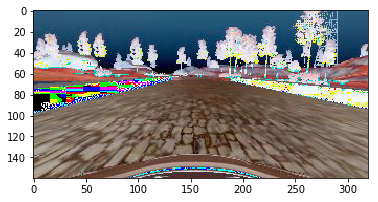

In [10]:
plt.imshow(image_array)

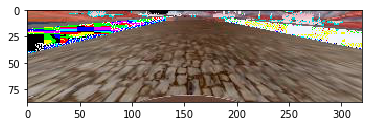

In [11]:
top = math.ceil(image_array.shape[0]*0.35)                                                                          
bot = math.ceil(image_array.shape[0]-image_array.shape[0]*0.1)                                                      
image_array = image_array[top:bot, :] 
plt.imshow(image_array)

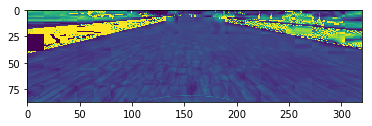

In [12]:
# graycolor the image                                                                                               
image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV) [:,:,1]  
plt.imshow(image_array)

y: 0.0


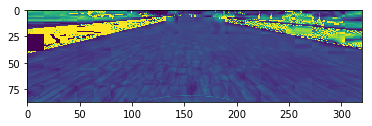

In [13]:
# randomly shear the image                                                                                          
image_array,y = random_shear(image_array,y)
print('y:',y)
plt.imshow(image_array)

y: 0.0


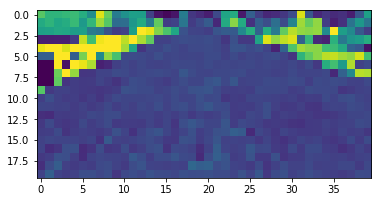

In [14]:
# resize the image                                   
image_array = cv2.resize(image_array,(cols,rows))
print('y:',y)
plt.imshow(image_array)

y: -0.0


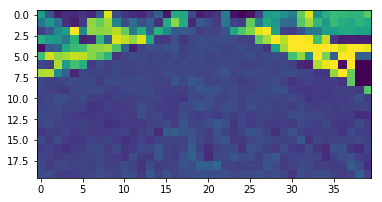

In [15]:
image_array,y = random_flip(image_array,y)
print('y:',y)
plt.imshow(image_array)

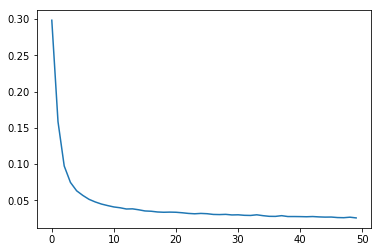

In [57]:
x = [0.2983,0.1584,0.0973,0.0747,0.0631,0.0567,0.0513,0.0477,0.0448,0.0427,0.0408,0.0397,0.0380,0.0382,0.0369,0.0353,0.0349,0.0339,0.0335,0.0337,0.0335,0.0328,0.0319,0.0314,0.0319,0.0315,0.0305,0.0303,0.0306,0.0298,0.0300,0.0293,0.0291,0.0300,0.0288,0.0279,0.0278,0.0288,0.0276,0.0276,0.0275,0.0273,0.0276,0.0271,0.0268,0.0269,0.0262,0.0260,0.0267,0.0257]
plt.plot(x)
plt.savefig('losscurve.png')

In [37]:
img=mpimg.imread('losscurve.png')

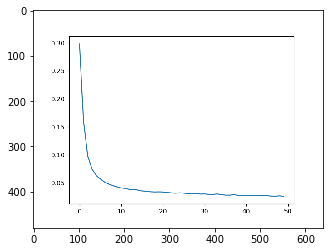

In [38]:
plt.imshow(img)

## show the distribution of before and after the image preprocessing

In [16]:
def load_data(X,y,path):                                                                                                
    print('start loading data...')                                                                                      
    t = time.process_time()                                                                                             
    side_camera_adjustment = .23                                                                                        
    f = open(path + '/driving_log.csv')                                                                                 
    for line in f:                                                                                                      
        line = line.split(',')                                                                                          
                                                                                                                        
        # center camera                                                                                                 
        im = read_image(path+'/'+line[0].strip()) # center image                                                        
        angle = float(line[3])                                                                                          
        X.append(im)                                                                                                    
        y.append(angle)                                                                                                 
                                                                                                                        
        #left camera                                                                                                    
        if line[1].strip():                                                                                             
            im = read_image(path+'/'+line[1].strip())                                                                   
            angle = angle + side_camera_adjustment # if this close, steer to the right                                  
            X.append(im)                                                                                                
            y.append(angle)                                                                                             
                                                                                                                        
                                                                                                                        
        #right camera                                                                                                   
        if line[2].strip():                                                                                             
            im = read_image(path+'/'+line[2].strip())                                                                   
            angle = angle - side_camera_adjustment # if this close, steer to the right                                  
            X.append(im)                                                                                                
            y.append(angle)                                                                                             
                                                                                                                        
    elapsed_time = time.process_time() - t                                                                              
    print('end loading data ---~> {}'.format(elapsed_time))                                                             
    print('mean y before augumentation ', np.mean(y))  
    f.close()                                                                                                           
    return X,y   

In [17]:
X = []                                                                                                              
y = []                                                                                                              
X,y = load_data(X,y,data_dir)                                                                                       
X = np.array(X).astype('float32')                                                                                   
y = np.array(y).astype('float32') 

start loading data...
end loading data ---~> 29.767205234
mean y before augumentation  0.0807363107315


In [18]:
import numpy as np
import scipy.stats as stats
import pylab as pl


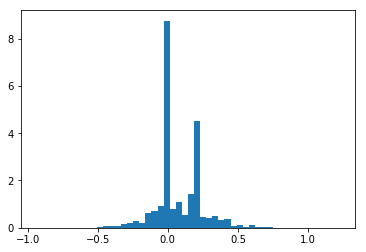

In [19]:
pl.hist(y,50,normed=True)
pl.savefig('rawdist.png')

In [22]:
                                                                                                                        
def random_shear(image,steering,prob=0.5):                                                                              
    # tnx: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.yozfr1waw       
    if np.random.random_sample() > prob:                                                                                
        rows = image.shape[0]                                                                                           
        cols = image.shape[1]                                                                                           
        shear_range = math.ceil(cols/3)                                                                                 
        dx = np.random.randint(-shear_range,shear_range+1)                                                              
        random_point = [cols/2+dx,rows/2]                                                                               
        pts1 = np.float32([[0,rows],[cols,rows],[cols/2,rows/2]])                                                       
        pts2 = np.float32([[0,rows],[cols,rows],random_point])                                                          
        dsteering = dx/(rows/2) * 360/(2*np.pi*25.0) / 3.0                                                              
        M = cv2.getAffineTransform(pts1,pts2)                                                                           
        image = cv2.warpAffine(image,M,(cols,rows),borderMode=1)                                                        
        steering +=dsteering                                                                                            
    return image,steering                                                                                               
                                                                                                                        
                                                                                                                        
def random_flip(im,angle,prob=0.5):                                                                                     
    if np.random.random_sample() > prob:                                                                                
        return np.fliplr(im),angle * -1.0                                                                               
    else:                                                                                                               
        return im,angle                                                                                                 
                                                                                                                        
                                                                                                                        
                                                                                                                        
def read_image(filename):                                                                                               
    newimage = Image.open(filename)                                                                                     
    image_array = np.asarray(newimage)                                                                                  
    return image_array                                                                                                  
                                                                                                                        
def process_image(image_array,y):                                                                                       
    # crop the image                                                                                                    
    top = math.ceil(image_array.shape[0]*0.30)                                                                          
    bot = math.ceil(image_array.shape[0]-image_array.shape[0]*0.1)                                                      
    image_array = image_array[top:bot, :]                                                                               
                                                                                                                        
    # color the image                                                                                                   
    image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2YUV)                                                          
                                                                                                                        
    # randomly shear the image                                                                                          
    image_array,y = random_shear(image_array,y)                                                                         
                                                                                                                        
    # resize the image                                                                                                  
    image_array = cv2.resize(image_array,(cols,rows))                                                                   
    # flip randomly the image                                                                                           
                                                                                                                        
    image_array,y = random_flip(image_array,y)                                                                          
                                                                                                                        
                                                                                                                        
    return image_array,y

def load_data(X,y,path):                                                                                                
    print('start loading data...')                                                                                      
    t = time.process_time()                                                                                             
    side_camera_adjustment = .23                                                                                        
    f = open(path + '/driving_log.csv')                                                                                 
    for line in f:                                                                                                      
        line = line.split(',')                                                                                          
                                                                                                                        
        # center camera                                                                                                 
        im = read_image(path+'/'+line[0].strip()) # center image                                                        
        angle = float(line[3])                                                                                          
        X.append(im)                                                                                                    
        y.append(angle)                                                                                                 
                                                                                                                        
        #left camera                                                                                                    
        if line[1].strip():                                                                                             
            im = read_image(path+'/'+line[1].strip())                                                                   
            angle = angle + side_camera_adjustment # if this close, steer to the right                                  
            X.append(im)  
            y.append(angle)
                                                                                                                        
                                                                                                                        
                                                                                                                        
        #right camera                                                                                                   
        if line[2].strip():                                                                                             
            im = read_image(path+'/'+line[2].strip())                                                                   
            angle = angle - side_camera_adjustment # if this close, steer to the right                                  
            X.append(im)                                                                                                
            y.append(angle)                                                                                             
                                                                                                                        
    elapsed_time = time.process_time() - t                                                                              
    print('end loading data ---~> {}'.format(elapsed_time))                                                             
    print('mean y before augumentation ', np.mean(y))                                                                   
                                                                                                                        
    for i in range(len(y)):                                                                                             
                                                                                                                        
        # augument the image                                                                                            
        X[i],y[i] = process_image(X[i],y[i])                                                                            
                                                                                                                        
    print('mean y after augumentation ', np.mean(y))                                                                    
    f.close()                                                                                                           
    return X,y 

In [23]:
X = []                                                                                                              
y = []                                                                                                              
X,y = load_data(X,y,data_dir)                                                                                       
X = np.array(X).astype('float32')                                                                                   
y = np.array(y).astype('float32') 

start loading data...
end loading data ---~> 28.896437039999995
mean y before augumentation  0.0807363107315
mean y after augumentation  0.00158035316263


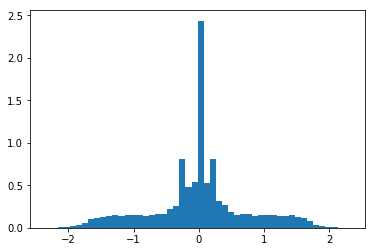

In [24]:
pl.hist(y,50,normed=True)
pl.savefig('normdist.png')